## Load Libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import shap

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext watermark
%watermark --iversions

keras : 3.12.0
numpy : 1.26.4
pandas: 2.3.3
shap  : 0.49.1



# Load data

In [2]:
x_train_Znorm = pd.read_csv('data/x_train_Znorm.csv')
x_val_Znorm = pd.read_csv('data/x_val_Znorm.csv')
y_train = np.load('data/y_train.npy')
y_val = np.load('data/y_val.npy')

## Calculate SHAP values

In [ ]:
background = x_val_Znorm
shap_array = np.empty((28, 60, 72, 6)) 
for i in range(0,28):
    model= load_model(f'data/best_model_v2_{i+1}.keras')
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(x_val_Znorm.sample(60).values)
    shap_array[i] = shap_values
#np.save('data/shap_array',shap_array)    

In [3]:
shap_array = np.load('data/shap_array.npy')

## SHAP plot statistic

In [4]:
# Individual parameter importance
shape_norms=np.sum(np.abs(shap_array),axis=(1,2,3))# Normalization for each model
shape_values_=np.ndarray((28,72))
for i in range(0,shap_array.shape[0]):
    shape_values_[i]=np.sum(np.abs(shap_array[i]),axis=(0,2))/shape_norms[i]
shap_iter=np.mean(shape_values_,axis=0)
shap_iter_std=np.std(shape_values_,axis=0)

#Summ of parameters for physical parameters
shap_iter_sum=np.mean(shape_values_.reshape(28, 9, 8).sum(axis=2),axis=0)
shap_iter_std_sum=np.std(shape_values_.reshape(28, 9, 8).sum(axis=2),axis=0)

#### One plot

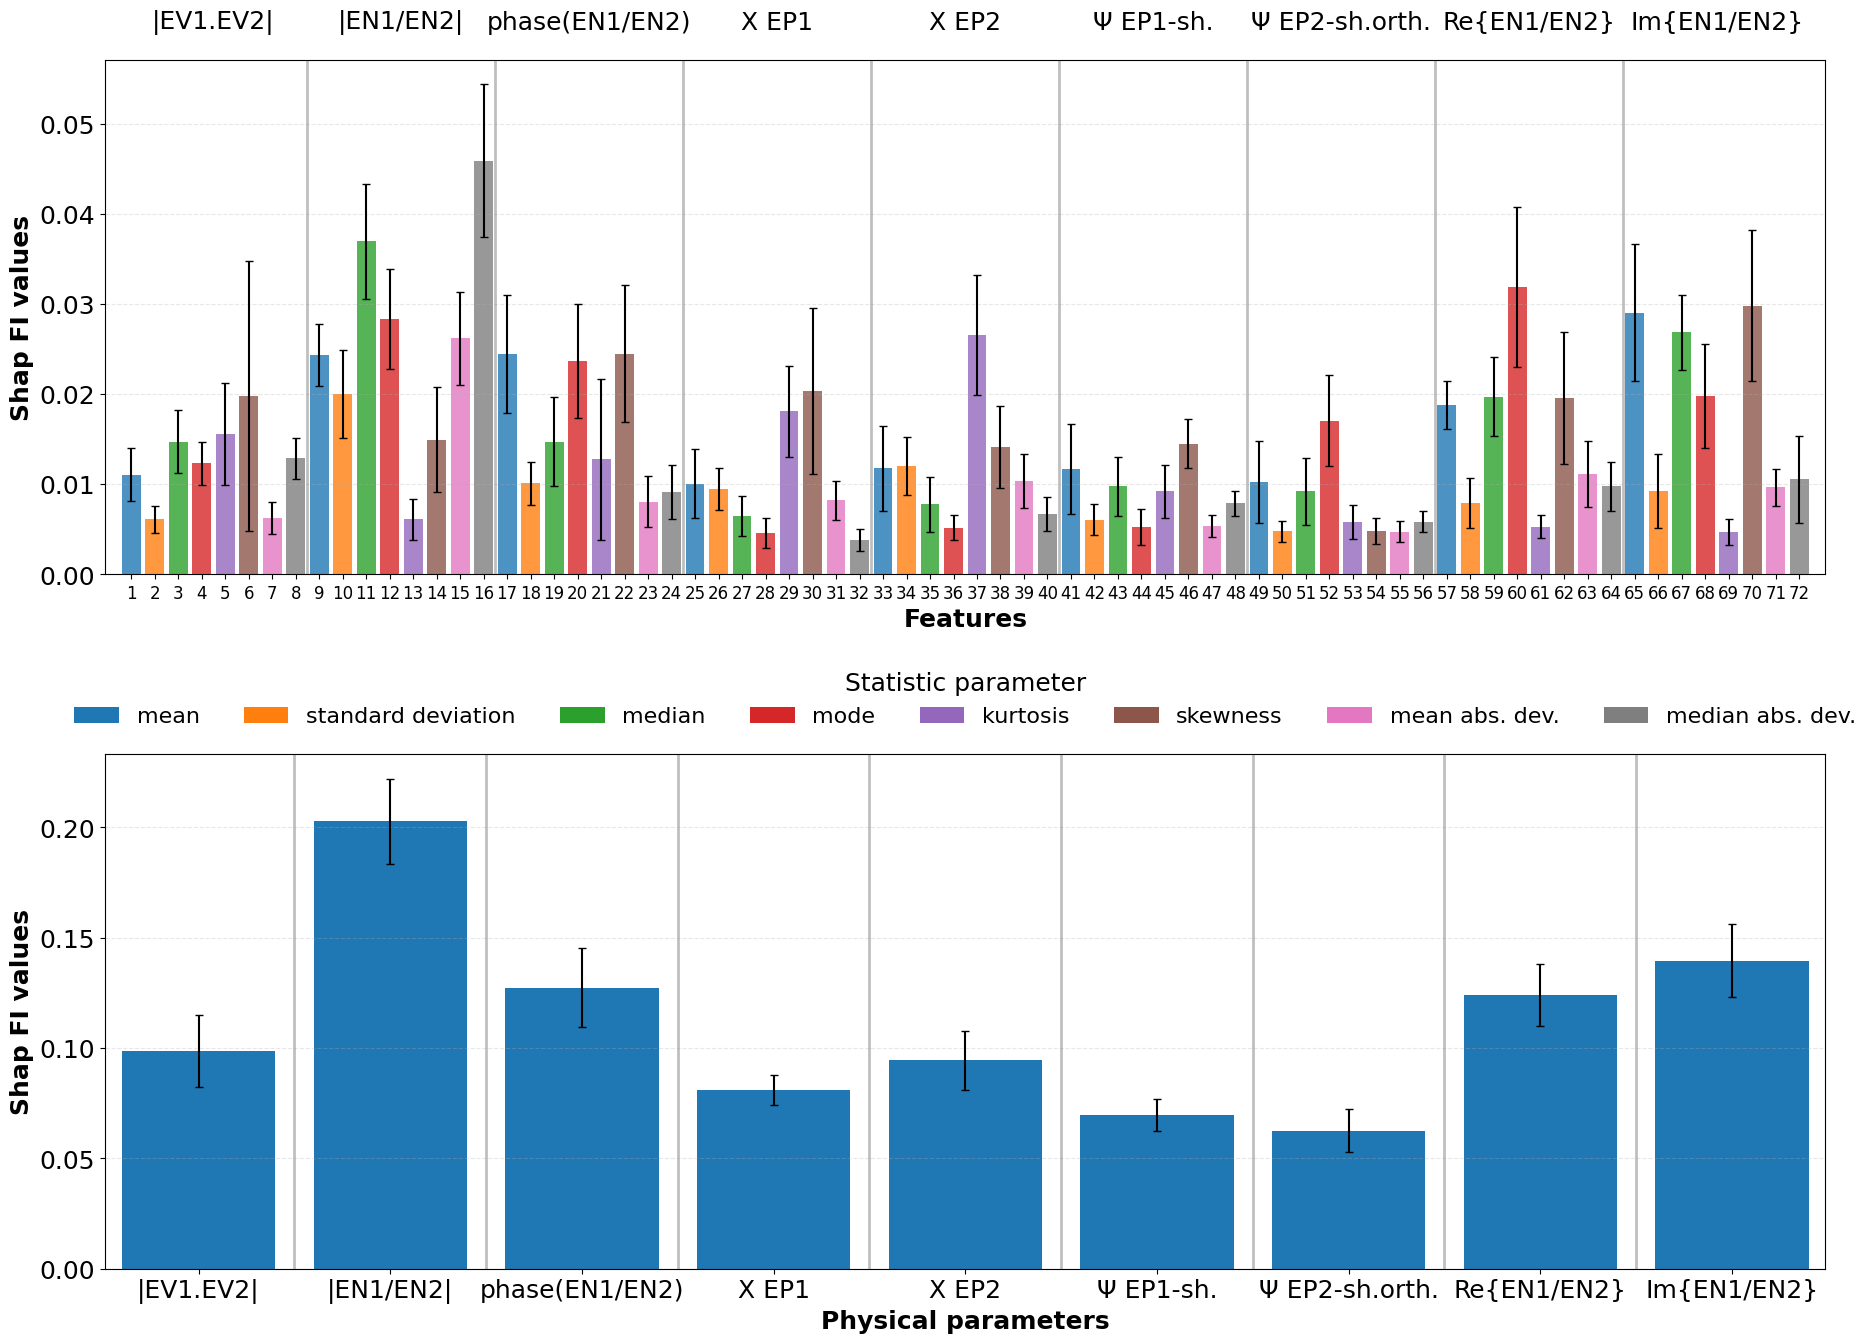

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

indices = np.arange(1, 73)

# Skupiny pro detailní graf
groups = {
    '|EV1.EV2|': range(1, 9),
    '|EN1/EN2|': range(9, 17),
    'phase(EN1/EN2)': range(17, 25),
    'Χ EP1': range(25, 33),
    'Χ EP2': range(33, 41),
    'Ψ EP1-sh.': range(41, 49),
    'Ψ EP2-sh.orth.': range(49, 57),
    'Re{EN1/EN2}': range(57, 65),
    'Im{EN1/EN2}': range(65, 73)
}

n_per_group = 8
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

# Vytvoření figury se 2 subploty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14))

# Horní graf: detailní (data A)
for i, (group_name, idx_range) in enumerate(groups.items()):
    start_idx = idx_range.start - 1
    end_idx = idx_range.stop - 1
    
    for j in range(start_idx, end_idx):
        ax1.bar(indices[j], shap_iter[j], 
                yerr=shap_iter_std[j] if 'shap_iter_std' in locals() else None,
                color=colors[j % n_per_group], 
                capsize=3, alpha=0.8)
    
    if i < len(groups) - 1:
        ax1.axvline(x=end_idx + 0.5, color='gray', linestyle='-', alpha=0.5, linewidth=2)

# Názvy skupin nad sloupci
ylim1 = ax1.get_ylim()
for group_name, idx_range in groups.items():
    start_idx = idx_range.start
    end_idx = idx_range.stop - 1
    x_pos = (start_idx + end_idx) / 2
    ax1.text(x_pos, ylim1[1] + (ylim1[1] - ylim1[0]) * 0.05,
             group_name, ha='center', va='bottom', fontsize=18)

ax1.set_ylim(0, ylim) if 'ylim' in locals() else None
ax1.set_xlabel('Features', fontsize=18, fontweight='bold')
ax1.set_ylabel('Shap FI values', fontsize=18, fontweight='bold')
ax1.set_xticks(indices)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=18)
#ax1.tick_params(labelsize=16)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.margins(x=0.01)

# Legenda
legend_name = ['mean','standard deviation', 'median','mode','kurtosis','skewness','mean abs. dev.','median abs. dev.']
legend_elements = [Patch(facecolor=colors[i], label=legend_name[i]) for i in range(n_per_group)]
ax1.legend(handles=legend_elements, title='Statistic parameter', 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(legend_elements), 
           frameon=False, fontsize=16, title_fontsize=18)

# Dolní graf: jednoduchý souhrn (data B)
# Dolní graf: jednoduchý souhrn (data B)
groups_simple = ['|EV1.EV2|','|EN1/EN2|','phase(EN1/EN2)','Χ EP1','Χ EP2',
                 'Ψ EP1-sh.','Ψ EP2-sh.orth.','Re{EN1/EN2}','Im{EN1/EN2}']

# Pozice sloupců pro kategorickou osu (0..8)
x_pos = np.arange(len(groups_simple))

ax2.bar(x_pos, shap_iter_sum, yerr=shap_iter_std_sum, capsize=3)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(groups_simple, fontsize=18)

# Vertikální čáry mezi skupinami (po každém sloupci kromě posledního)
for k in range(len(groups_simple) - 1):
    ax2.axvline(x=k + 0.5, color='gray', linestyle='-', alpha=0.5, linewidth=2)

ax2.tick_params(axis='y', labelsize=18)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_xlabel('Physical parameters', fontsize=18, fontweight='bold')
ax2.set_ylabel('Shap FI values', fontsize=18, fontweight='bold')
ax2.margins(x=0.01)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.35)
plt.savefig('data/plot_shap_invd_summ.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


## SHAP per classess

In [6]:

shape_norms_class=np.sum(np.abs(shap_array),axis=(1,2))# Normalization for each model and class 
shape_values_class=np.ndarray((28,72,6))
for i in range(0,shap_array.shape[0]):
    shape_values_class[i]=np.sum(np.abs(shap_array[i]),axis=(0))/shape_norms_class[i]
shap_iter_class=np.mean(shape_values_class.reshape(28, 9, 8, 6).sum(axis=2),axis=0)
shap_iter_class_std=np.std(shape_values_class.reshape(28, 9, 8, 6).sum(axis=2),axis=0)

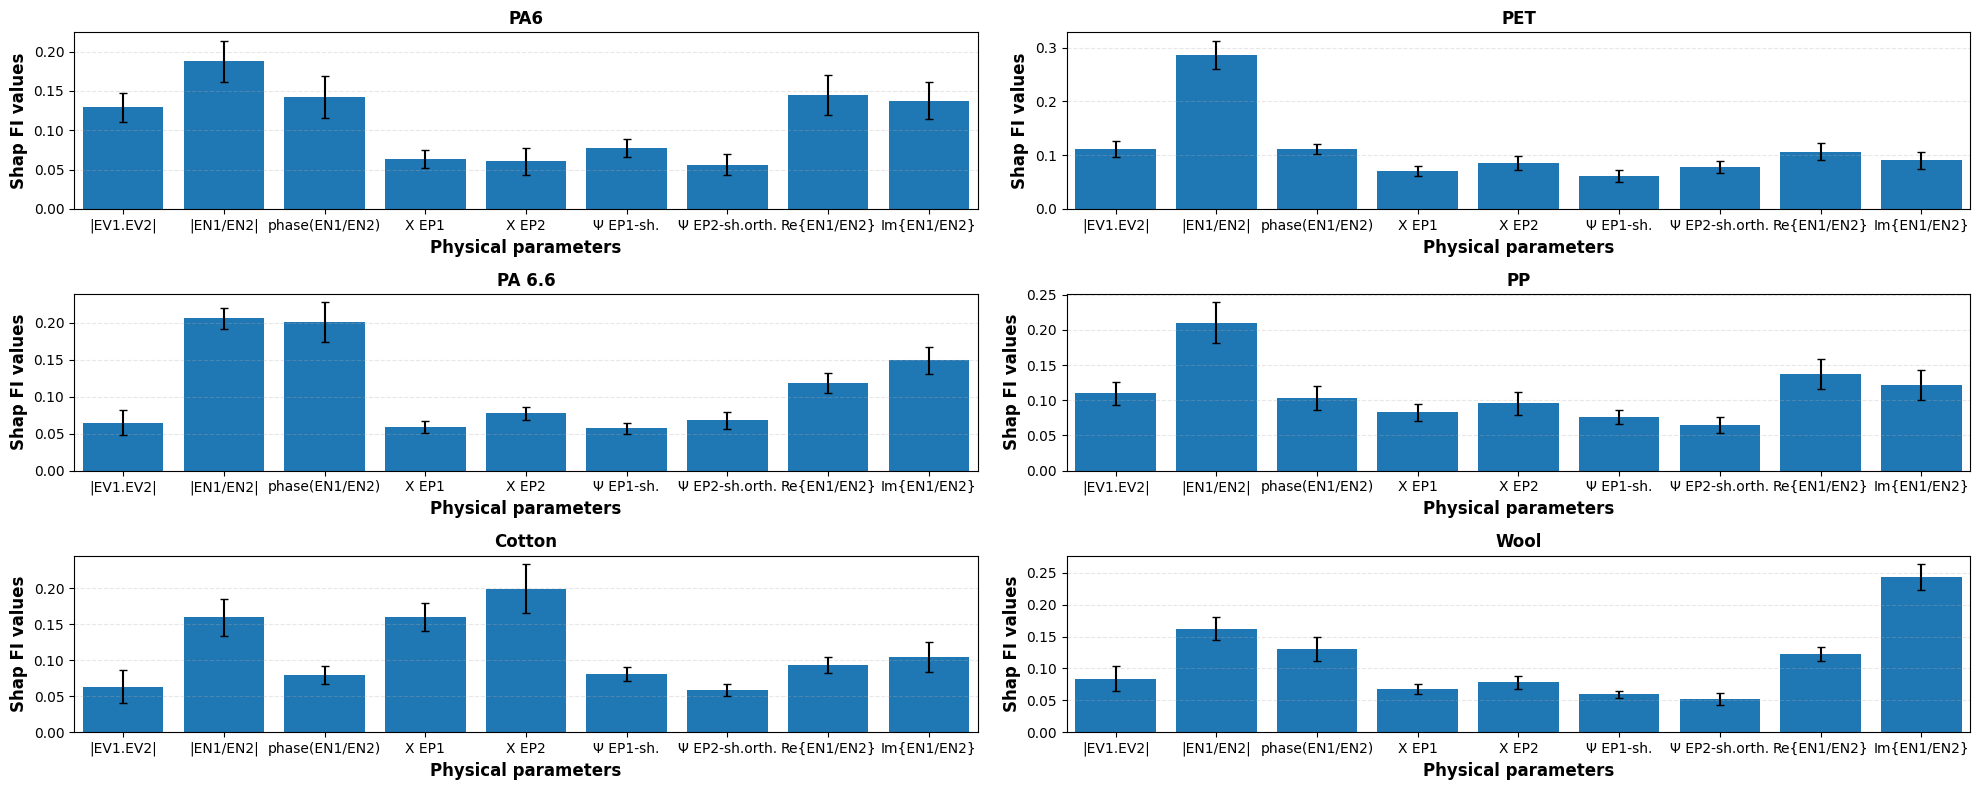

In [ ]:
# Groups and their index ranges
groups = ['|EV1.EV2|','|EN1/EN2|','phase(EN1/EN2)','Χ EP1','Χ EP2','Ψ EP1-sh.','Ψ EP2-sh.orth.','Re{EN1/EN2}','Im{EN1/EN2}']
label = ['PA6','PET','PA 6.6','PP','Cotton','Wool']

# Plot bars for each group
fig, axes = plt.subplots(3, 2, figsize=(20, 8))  # 2 řádky, 3 sloupce
for j, ax in enumerate(axes.flat):
    ax.bar(groups,shap_iter_class[:,j],yerr=shap_iter_class_std[:,j],capsize=3)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlabel('Physical parameters', fontsize=12, fontweight='bold')
    ax.set_ylabel('Shap FI values', fontsize=12, fontweight='bold')
    ax.set_title(label[j], fontsize=12, fontweight='bold')
    ax.margins(x=0.01, tight=True)
plt.tight_layout()
plt.savefig('data/plot_shap_summ_classes.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()